<img src="./LSH.webp" alt="A digital collage illustrating the concept of image similarity search using Locality Sensitive Hashing" width="1024"/>

**Name:Shayan Aryania**

**Student Number: 402211767**

# Overview of Image Similarity Search Using Locality Sensitive Hashing (LSH)
## Problem Introduction:

In the vast and growing domain of digital media, efficiently searching for similar images in a large database is a critical challenge. This task is crucial in various applications such as digital asset management, content-based image retrieval, and even in enhancing user experiences on platforms where visual content is predominant.

## Why Image Similarity Search?

Traditional methods of image retrieval rely on metadata or tags, which can be incomplete or subjective. An effective image similarity search system assesses the content of the images directly, making it possible to find matches based on visual similarity regardless of how the images are labeled.

## Challenges:

- High Dimensionality: Images, when converted into feature vectors, exist in high-dimensional spaces, making similarity search computationally intensive and time-consuming.
- Scalability: As the size of the image database grows, ensuring the search method scales efficiently is paramount.
- Accuracy: Balancing precision and recall in the search results to ensure that the system is both reliable and useful.
## Our Goal:

The aim of this project is to implement and evaluate a Locality Sensitive Hashing (LSH) approach for image similarity search. LSH is a probabilistic method that hashes similar items into the same "buckets" with high probability, thus reducing the dimensions and allowing faster retrieval:

- Efficiency: By using hashing, we aim to reduce the time complexity of searches from linear to sub-linear time.
- Effectiveness: Even though LSH is an approximation technique, we strive to achieve a high degree of precision and recall in identifying similar images.
- Scalability: LSH is particularly known for handling large datasets effectively, making it suitable for our needs.
Implementation Strategy:

We will use a subset of the CIFAR-10 dataset to develop and test our LSH implementation. The project will guide you through setting up the dataset, extracting features using a pre-trained CNN model, implementing the LSH algorithm, and evaluating its performance based on various metrics.

By the end of this notebook, you should have a functional image similarity search tool that could be adapted for larger, more complex datasets or integrated into a broader application for real-time image retrieval.

# Setup

In [1]:
import torch
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from PIL import Image
import numpy as np
from sklearn.neighbors import NearestNeighbors
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from tqdm import tqdm
import random
import time
from collections import defaultdict

# Setting up The `CIFAR10` Dataset
Here, we define and download the CIFAR10 dataset, applying transformations to normalize the data for processing. This dataset will be used to train and test our image similarity search.

In [2]:
# Define the transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # CIFAR-10 normalization
])

# Download the CIFAR-10 dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170498071/170498071 [04:15<00:00, 666136.73it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data


# Data Sampling
We will sample 100 images per class from the CIFAR-10 dataset. This ensures a balanced dataset which is crucial for maintaining fairness and accuracy in our similarity search.

In [3]:
# We want to sample 100 images per class
class_indices = {i: [] for i in range(10)}  # Dictionary to store indices for each class
# Collect indices for each class
for idx, (_, label) in tqdm(enumerate(trainset)):
    class_indices[label].append(idx)
# Limit to 100 samples per class
limited_indices = [idx for indices in class_indices.values() for idx in random.sample(indices, k=100)]
subset_trainset = Subset(trainset, limited_indices)
# Create a DataLoader for the subset
trainloader = DataLoader(subset_trainset, batch_size=10, shuffle=True)

50000it [00:11, 4179.97it/s]


# Plotting Sample Images
To visually verify our data sampling, we plot a grid showing images:

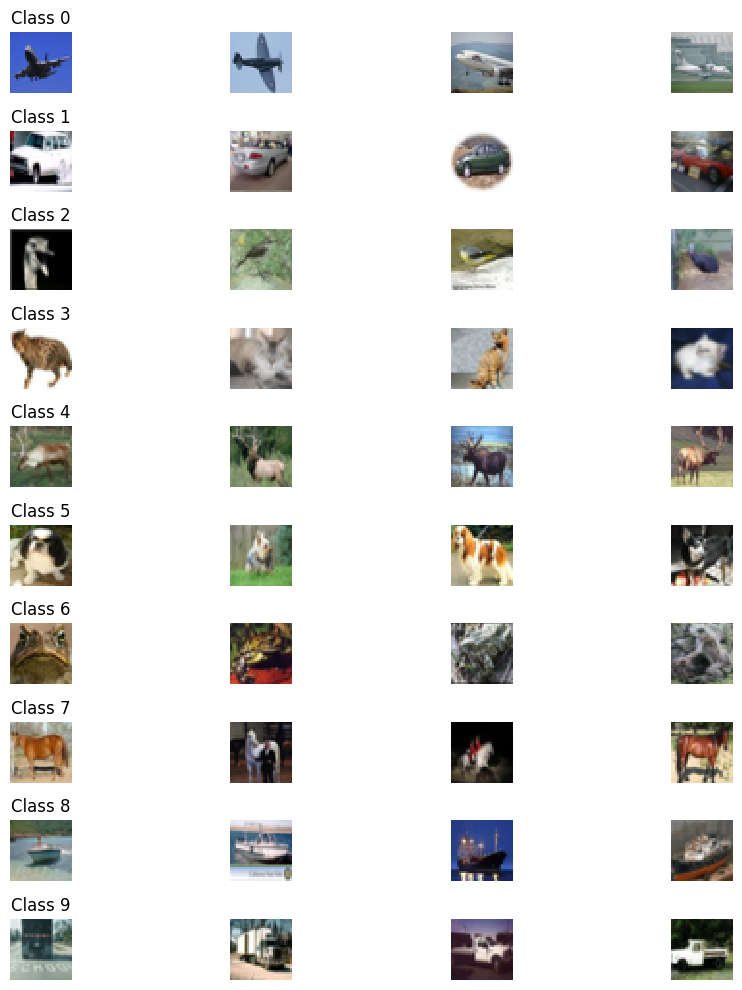

In [4]:
# Create a dictionary to hold images for each class
class_images = {i: [] for i in range(10)}
# Gather 4 images per class
for images, labels in trainloader:
    for image, label in zip(images, labels):
        if len(class_images[label.item()]) < 4:
            # Normalize image to [0, 1] for visualization
            image = image / 2 + 0.5  # Undo normalization
            image = np.transpose(image.numpy(), (1, 2, 0))  # Convert from Tensor image
            class_images[label.item()].append(image)
        # Check if we have collected enough images
        if all(len(imgs) == 4 for imgs in class_images.values()):
            break
# Plotting
fig, axs = plt.subplots(10, 4, figsize=(10, 10))  # 10 classes, 4 images each
for class_idx, imgs in class_images.items():
    for i, img in enumerate(imgs):
        ax = axs[class_idx, i]
        ax.imshow(img, interpolation='nearest')
        ax.axis('off')
        if i == 0:
            ax.set_title(f'Class {class_idx}')
plt.tight_layout()
plt.show()

# Feature Extraction
In this section, we use a pre-trained ResNet model to extract features from our images. These features are critical for the next step where we implement our LSH algorithm to find similar images.

In [5]:
# Load a pre-trained ResNet model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode
# Remove the final layer to get the feature extractor
feature_extractor = torch.nn.Sequential(*list(model.children())[:-1])
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
feature_extractor = feature_extractor.to(device)
# Extract features
features = []
labels = []
with torch.no_grad():
    for images, l in tqdm(trainloader):
        images = images.to(device)
        outputs = feature_extractor(images)
        outputs = outputs.view(outputs.size(0), -1)  # Flatten the features
        features.extend(outputs.cpu().numpy())
        labels.extend(l.cpu().numpy())

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /Users/shayanaryania/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [01:06<00:00, 705kB/s] 
100%|██████████| 100/100 [00:02<00:00, 35.58it/s]


# LSH Implementation
Now we implement the LSH class that uses hashing techniques to quickly find similar images based on the features extracted. This involves creating multiple hash tables to efficiently index and retrieve images.

In [6]:
# TODO: Implement Locality Sensitive Hashing (LSH)
# Your task is to implement an LSH class or function that can index image features
# and support querying similar images efficiently.

class LSH:
    def __init__(self, num_features, num_bins=10, num_tables=5):
        """
        Initialize the LSH object with multiple hash tables and fit projections.
        Args:
            num_features (int): Number of features in the input data.
            num_bins (int): Rough granularity of each bin in hash tables.
            num_tables (int): Number of hash tables (controls recall and precision).
        """
        self.num_features = num_features
        self.num_bins = num_bins
        self.num_tables = num_tables

        self.hash_tables = [{} for _ in range(num_tables)]
        self.fit_projections = [np.random.normal(size=(num_features, num_bins)) for _ in range(num_tables)]

        pass

    def _hash(self, features, table_idx):
        """
        Computes a hash for the given features using the specified hash table.
        Args:
            features (numpy.ndarray): Feature vector of the image.
            table_idx (int): Index of the hash table to use.
        Returns:
            tuple: A hash value generated from the features.
        """
        projection = np.dot(self.fit_projections[table_idx].T,features)
        return tuple(np.floor(projection / self.num_bins).astype(int))

    def index(self, features, labels):
        """
        Index image features into the LSH hash tables.
        Args:
            features (list of numpy.ndarray): List of feature vectors.
            labels (list): Corresponding labels of the feature vectors.
        """
        for i, feature in enumerate(features):
            for table_idx in range(self.num_tables):
                hash_value = self._hash(feature, table_idx)
                if hash_value not in self.hash_tables[table_idx]:
                    self.hash_tables[table_idx][hash_value] = []
                self.hash_tables[table_idx][hash_value].append(i)


    def query(self, query_features, num_results=10):
        """
        Query the LSH for similar images.
        Args:
            query_features (numpy.ndarray): Feature vector of the query image.
            num_results (int): Number of similar results to return.
        Returns:
            list of int: Indices of the top similar images found.
        """
        candidates = set()
        for table_idx in range(self.num_tables):
            hash_value = self._hash(query_features, table_idx)
            if hash_value in self.hash_tables[table_idx]:
                candidates.update(self.hash_tables[table_idx][hash_value])

        distances = {idx: np.linalg.norm(query_features - features[idx]) for idx in candidates}
        sorted_distances = sorted(distances.items(), key=lambda x: x[1])
        return [idx for idx, _ in sorted_distances[:num_results]]

Now we can test our implementation by querying similar images for a given input image:

In [7]:
# Initialize the LSH system
lsh = LSH(num_features=features[0].size,
          num_bins=10,
          num_tables=4)

# Index the features with their labels
lsh.index(features, labels)

In [8]:
# Query the LSH with the first feature vector to find similar images
query_index = 2
query_feature = features[query_index]
num_results = 5

similar_indices = lsh.query(query_feature, num_results=num_results)

# Output the results
print("Query Index:", query_index)
print("True Label of Query Image:", labels[query_index])
print("Indices of Similar Images:", similar_indices)
print("Labels of Similar Images:", [labels[idx] for idx in similar_indices])

Query Index: 2
True Label of Query Image: 0
Indices of Similar Images: [2]
Labels of Similar Images: [0]


# Testing and Evaluation
Finally, we test our LSH implementation using a set of images and evaluate its performance in terms of precision, recall, and query response time. This helps us understand the effectiveness and efficiency of our image similarity search approach.

In [9]:
# Assuming `features` and `labels` are already defined and correspond to each other
# Sample 10 images per class for the test set
test_indices = {label: np.random.choice(np.where(labels == label)[0], 10, replace=False) for label in np.unique(labels)}

# Flatten the dictionary to a list of indices
test_indices_flat = [idx for indices in test_indices.values() for idx in indices]

# Test features and labels
test_features = [features[idx] for idx in test_indices_flat]
test_labels = [labels[idx] for idx in test_indices_flat]

In [10]:
# Instantiate the LSH class
lsh = lsh = LSH(num_features=features[0].size,
                num_bins=10,
                num_tables=5)

# Measure indexing time
start_time = time.time()
lsh.index(features, labels)
indexing_time = time.time() - start_time
print(f"Indexing Time: {indexing_time:.4f} seconds")

Indexing Time: 0.0753 seconds


In [11]:
# Function to evaluate the LSH implementation
def evaluate_lsh(lsh, test_features, test_labels):
    precision_accum = 0
    recall_accum = 0
    query_times = []

    # For each test feature, query the LSH and measure precision and recall
    for test_feature, true_label in zip(test_features, test_labels):
        start_query_time = time.time()
        results = lsh.query(test_feature, num_results=3)
        query_times.append(time.time() - start_query_time)

        # Assume `results` returns a list of indices of the found images
        result_labels = [labels[idx] for idx in results]

        # Calculate precision and recall
        true_positives = sum(1 for result_label in result_labels if result_label == true_label)
        retrieved = len(result_labels)
        relevant = sum(1 for label in labels if label == true_label)

        precision = true_positives / retrieved if retrieved > 0 else 0
        recall = true_positives / relevant if relevant > 0 else 0

        precision_accum += precision
        recall_accum += recall

    # Calculate average precision, recall, and query response time
    avg_precision = precision_accum / len(test_features)
    avg_recall = recall_accum / len(test_features)
    avg_query_time = np.mean(query_times)

    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average Query Response Time: {avg_query_time:.4f} seconds")

    return avg_precision, avg_recall, avg_query_time

# Evaluate the LSH implementation
evaluate_lsh(lsh, test_features, test_labels)

Average Precision: 0.9900
Average Recall: 0.0100
Average Query Response Time: 0.0001 seconds


(0.99, 0.010000000000000007, 0.00012857437133789062)